# Using TimeGAN by ydata-synthetics

We will try to replicate the [TimeGAN demo made bt ydata-synthetics](https://github.com/ydataai/ydata-synthetic/blob/dev/examples/timeseries/stock_timegan.py), using our own abstractions.

## Initial Setup

This notebook depends on the `ydata-synthetic` library. To install it from a downloaded version, please run the following

In [21]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import sys
from os import chdir

VERTEX: bool = False
WORKING_DIRECTORY:str = "C:\\PythonProjects\\paqarin"
TRAINING_DATA_FILE: str = "data\\stock_data.csv"

evaluation_iterations: int = 3
scorer_epochs: int =  10
epochs: int = 10 # On the example, 50K. We're keeping it at 50 for quick prototyping.

if VERTEX:
    WORKING_DIRECTORY = "/home/jupyter/paqarin"
    TRAINING_DATA_FILE = "data/stock_data.csv"

    !{sys.executable} -m pip install ydata-synthetic
    !{sys.executable} -m pip install dask

chdir(WORKING_DIRECTORY)
import paqarin

Setup working directory:

In [22]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
sns.set_theme()

# Setting up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Checking GPU availability
import tensorflow as tf
logging.info(f"Available GPUS: {tf.config.list_physical_devices('GPU')}")
logging.info(f"Is built with CUDA: {tf.test.is_built_with_cuda()}")


INFO:root:Available GPUS: []
INFO:root:Is built with CUDA: False


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Configuring the Evaluation Pipeline

We will initially use [the stock data file provided by ydata](https://github.com/ydataai/ydata-synthetic/blob/dev/data/stock_data.csv).


In [23]:
import pandas as pd

training_dataframe: pd.DataFrame = pd.read_csv(TRAINING_DATA_FILE)
training_dataframe

,Open,High,Low,Close,Adj_Close,Volume
0,49.676899,51.693783,47.669952,49.845802,49.845802,44994500
1,50.178635,54.187561,49.925285,53.805050,53.805050,23005800
2,55.017166,56.373344,54.172661,54.346527,54.346527,18393200
3,55.260582,55.439419,51.450363,52.096165,52.096165,15361800
4,52.140873,53.651051,51.604362,52.657513,52.657513,9257400
...,...,...,...,...,...,...
3680,1207.479980,1216.300049,1200.500000,1205.920044,1205.920044,1017800
3681,1205.939941,1215.670044,1204.130005,1215.000000,1215.000000,950000
3682,1214.989990,1216.219971,1205.030029,1207.150024,1207.150024,907200
3683,1207.890015,1208.689941,1199.859985,1203.839966,1203.839966,860200


Over 3K data points. We start training an `EvaluationPipeline` instance:

In [24]:
%%time

from paqarin.evaluation import EvaluationPipeline
from paqarin import multivariate_metrics
from joblib import dump, load
from os import path
from typing import List

from paqarin.generators import TimeGanGenerator, TimeGanParameters
from paqarin import ydata_adapter

TIME_GAN_FILE: str = "models/timegan_generator.pkl"

data_columns: List[str] = training_dataframe.columns.tolist()
provider: str = "ydata"
batch_size: int = 32
learning_rate: float = 5e-4
noise_dimension: int = 32 # Also feel it's not used
layers_dimension: int = 128 # Not sure what this parameter means/does. I don't think it's used at all
latent_dimension: int = 24
gamma: int = 1 # A discriminator loss parameter. Couldn't find a reference in the paper.
sequence_length: int = 24
number_of_sequences: int = 6 # A parameter of the recovery network.
synthetic_sequences: int = 3661 # Is the number of data blocks after pre-processing.

time_gan_parameters: TimeGanParameters = TimeGanParameters(
    batch_size=batch_size,
    learning_rate=learning_rate,
    noise_dimension=noise_dimension,
    layers_dimension=layers_dimension,
    latent_dimension=latent_dimension,
    gamma=gamma,
    epochs=epochs,
    sequence_length=sequence_length,
    number_of_sequences=number_of_sequences,
    numerical_columns=data_columns,
    filename=TIME_GAN_FILE)


if path.exists(TIME_GAN_FILE):
    time_gan_generator: TimeGanGenerator = ydata_adapter.load_timegan_generator(time_gan_parameters)
else:
    time_gan_generator: TimeGanGenerator = TimeGanGenerator(provider=provider,
                                                            generator_parameters=time_gan_parameters)


EVALUATION_METRIC: str = "mean_absolute_error"

lstm_units: int = 12
scorer_batch_size: int = 128
number_of_features: int = 6
predictive_scorer = multivariate_metrics.PredictiveScorer(
    lstm_units=lstm_units,
    scorer_epochs=scorer_epochs,
    iterations=evaluation_iterations,
    scorer_batch_size=scorer_batch_size,
    number_of_features=number_of_features,
    sequence_length=sequence_length,
    numerical_columns=data_columns,
    metric_value_key=EVALUATION_METRIC)

evaluation_pipeline: EvaluationPipeline = EvaluationPipeline(generator_map={"time_gan": time_gan_generator},
                                                             scoring=predictive_scorer)
evaluation_pipeline.fit(training_dataframe)

if not path.exists(TIME_GAN_FILE):
    evaluation_pipeline.generator_map["time_gan"].save()

Fitting transformer for time_gan
Fitting generator time_gan
Training YData-Synthetic TimeGAN implementation...
A DataProcessor is not available for the TimeGAN.


Joint networks training: 100%|██████████| 1/1 [00:58<00:00, 58.02s/it]
INFO:root:Training X shape: (2562, 23, 6) Training y shape: (2562, 6)
INFO:root:Validation X shape: (549, 23, 6) Validation y shape: (549, 6)
INFO:root:Testing X shape: (550, 23, 6) testing y shape: (550, 6)
INFO:root:0: Training an RNN model using real data...


21/21 [==============================] - 3s 28ms/step - loss: 0.3202 - val_loss: 0.2552


INFO:root:Obtaining predictions...


18/18 [==============================] - 0s 2ms/step


INFO:root:Generating 153 synthetic sequences using time_gan...
INFO:root:Training X shape: (2736, 23, 6) Training y shape: (2736, 6)
INFO:root:Validation X shape: (456, 23, 6) Validation y shape: (456, 6)
INFO:root:Testing X shape: (456, 23, 6) testing y shape: (456, 6)
INFO:root:0: Training an RNN model using synthetic data by time_gan...


22/22 [==============================] - 2s 27ms/step - loss: 0.3420 - val_loss: 0.2124


INFO:root:Obtaining predictions...


18/18 [==============================] - 0s 2ms/step


INFO:root:time_gan (Avg. MAE 0.2191834029235525) is better than None (MAE None)!
INFO:root:TimeGAN from ydata was saved at models/timegan_generator.pkl
INFO:root:TimeGAN transformer was saved at models/timegan_generator.pkl.transformer


CPU times: total: 1min 32s
Wall time: 1min 25s


Let's take a look at the performance metrics:

In [25]:
results_dataframe: pd.DataFrame = pd.DataFrame(evaluation_pipeline.training_results)
results_dataframe

,generator_name,avg_mean_absolute_error,std_mean_absolute_error
0,train_on_real,0.265398,0.0
1,time_gan,0.219183,0.0


Now lets plot some labels and predictions:

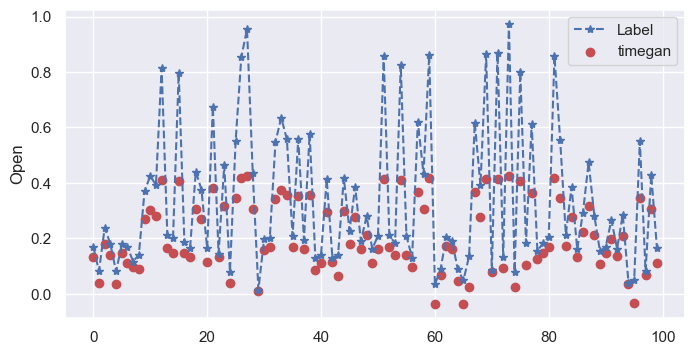

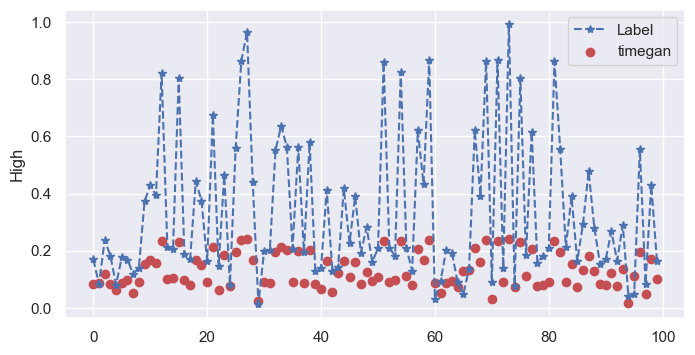

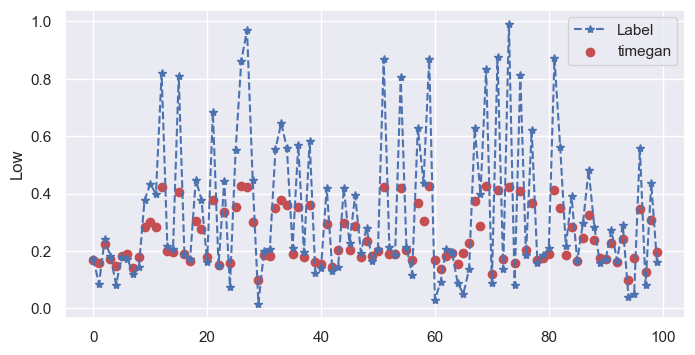

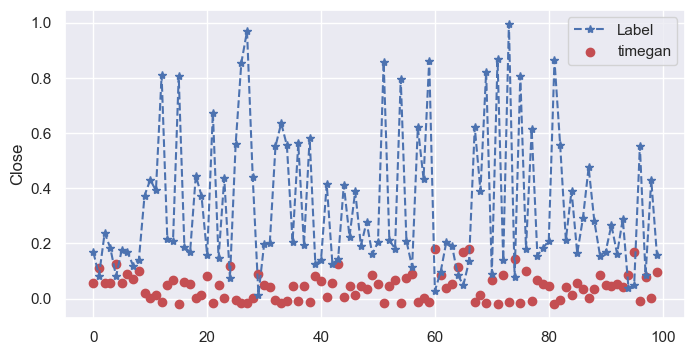

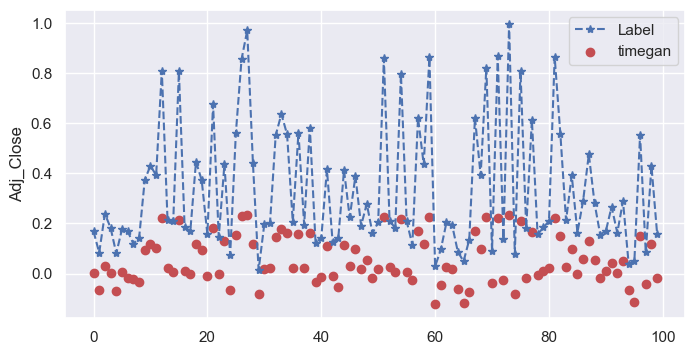

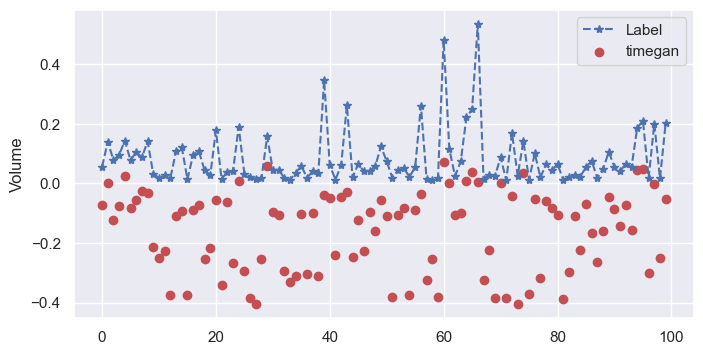

In [26]:
import numpy as np
from paqarin.utils import plot_predictions
from paqarin.evaluation import MetricManager

iteration_index: int = 0
samples_for_plotting: int = 100
metric_manager: MetricManager = predictive_scorer.metric_manager

labels: np.ndarray = predictive_scorer.testing_labels[: samples_for_plotting]
timegan_predictions: np.ndarray = metric_manager.get_iteration_values('time_gan', iteration_index, "training_predictions")[: samples_for_plotting]

figure_size: tuple[int, int] =(8, 4)
for column_index, column_name in enumerate(training_dataframe.columns):
    plot_predictions(labels=labels[:, column_index],
                     predictions=[("timegan", timegan_predictions[:, column_index])],
                     column_name=column_name,
                     figure_size=figure_size)


On my Windows laptop, 50 epoch training has a wall time of 1:42 minutes. Using `nvidia-smi -l 1`, I verified the GPU is been used.

## Evaluating the synthetic time series

The data generated by TimeGAN follows a specific format. Let's take a look at how this transformation works on the original data:

First, we start by loading the trained model from disk:

In [27]:
%%time

number_of_sequences: int = 10

trained_generator: TimeGanGenerator = ydata_adapter.load_timegan_generator(time_gan_parameters)
sample_sequences: List[np.ndarray] = trained_generator.generate(number_of_sequences)

print(f"Items in list: {len(sample_sequences)}")
print(f"Item shape: {sample_sequences[0].shape}")
print(f"Item type: {type(sample_sequences[0])}")

sample_sequences[:5]

INFO:root:Loading TimeGAN implementation from ydata stored at models/timegan_generator.pkl
INFO:root:Loading TimeGAN transformer from: models/timegan_generator.pkl.transformer


Items in list: 10
Item shape: (24, 6)
Item type: <class 'pandas.core.frame.DataFrame'>
CPU times: total: 15.6 s
Wall time: 15.7 s


[          Open        High         Low       Close   Adj_Close      Volume
 0   661.142151  659.575195  645.105164  648.805359  655.599182  40625264.0
 1   662.698547  655.012817  643.799988  635.733093  649.626709  39741228.0
 2   664.466492  649.890869  644.843689  623.764160  642.286560  38944316.0
 3   666.389160  645.375427  647.497070  614.573425  635.210571  38309312.0
 4   668.212036  641.870544  650.785706  608.164490  629.205688  37834616.0
 5   669.729187  639.350525  654.009705  603.956543  624.461487  37493820.0
 6   670.870605  637.630432  656.796692  601.318970  620.876038  37255804.0
 7   671.666992  636.501526  659.016296  599.741943  618.252869  37092348.0
 8   672.191467  635.783752  660.680908  598.855286  616.387207  36980856.0
 9   672.521484  635.337769  661.871033  598.403198  615.096497  36904640.0
 10  672.722473  635.063965  662.686829  598.213684  614.229675  36852012.0
 11  672.841797  634.896240  663.222534  598.173889  613.665405  36815192.0
 12  672.910

It appears they have extracted sequences of size 24, after normalising with min-max scaler. We now support denormalizaton when accessing training data values. For further details, check the `real_data_loading` function.

Now, let's format the synthetic samples, to obtain a single dataframe:

In [28]:
index_axis: int = 0
synthetic_dataframe: pd.DataFrame = pd.concat(sample_sequences, axis=index_axis)
synthetic_dataframe

,Open,High,Low,Close,Adj_Close,Volume
0,661.142151,659.575195,645.105164,648.805359,655.599182,40625264.0
1,662.698547,655.012817,643.799988,635.733093,649.626709,39741228.0
2,664.466492,649.890869,644.843689,623.764160,642.286560,38944316.0
3,666.389160,645.375427,647.497070,614.573425,635.210571,38309312.0
4,668.212036,641.870544,650.785706,608.164490,629.205688,37834616.0
...,...,...,...,...,...,...
19,672.968140,634.677185,663.933228,598.623108,612.834656,36729592.0
20,672.963928,634.674011,663.921265,598.646240,612.830811,36727604.0
21,672.961670,634.671265,663.911255,598.664307,612.826111,36726228.0
22,672.960754,634.669067,663.902832,598.678772,612.821289,36725308.0


During the fitting process `Paqarin` generates synthetic sequences, the same number as the training ones (after pre-processing). Let's plot them, to visually assess the similarity of the generated data. 

 **Important:** For ease we plot 3 synthetic sequences one after each other. The 3 sequences are likely not to be temporally continuous between themselves.

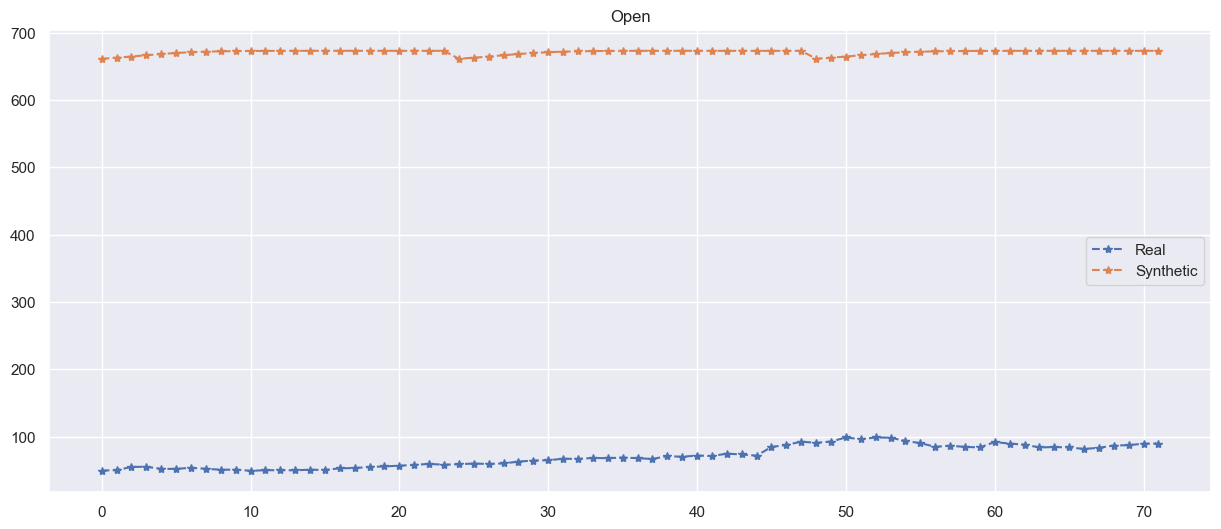

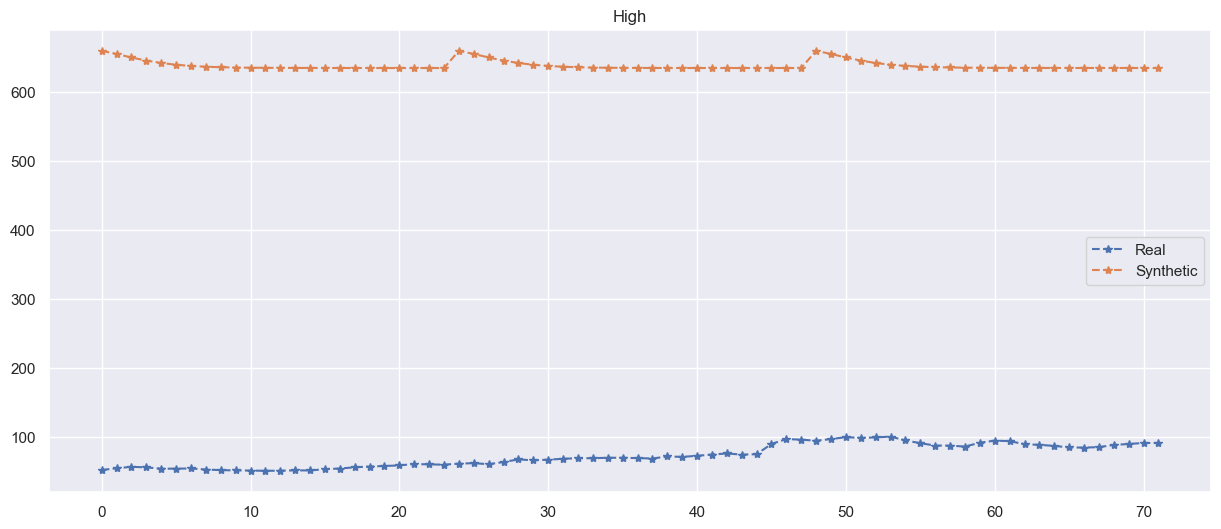

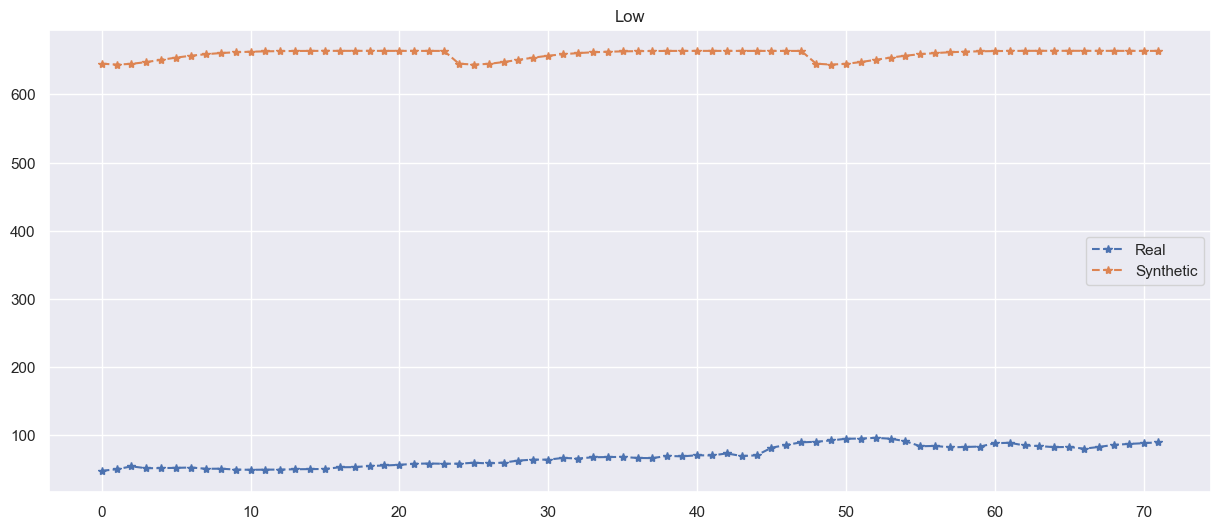

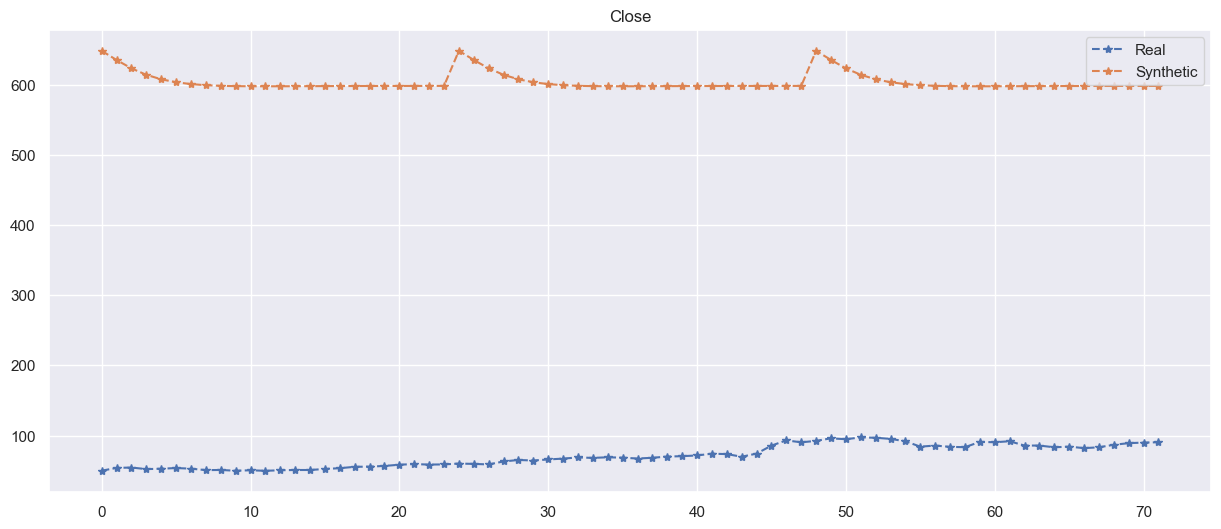

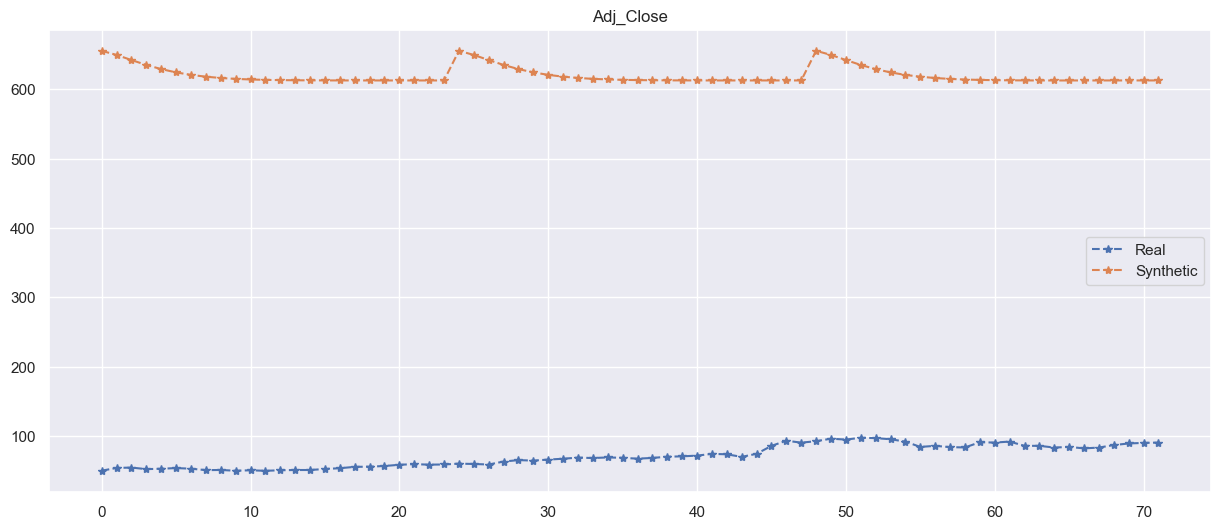

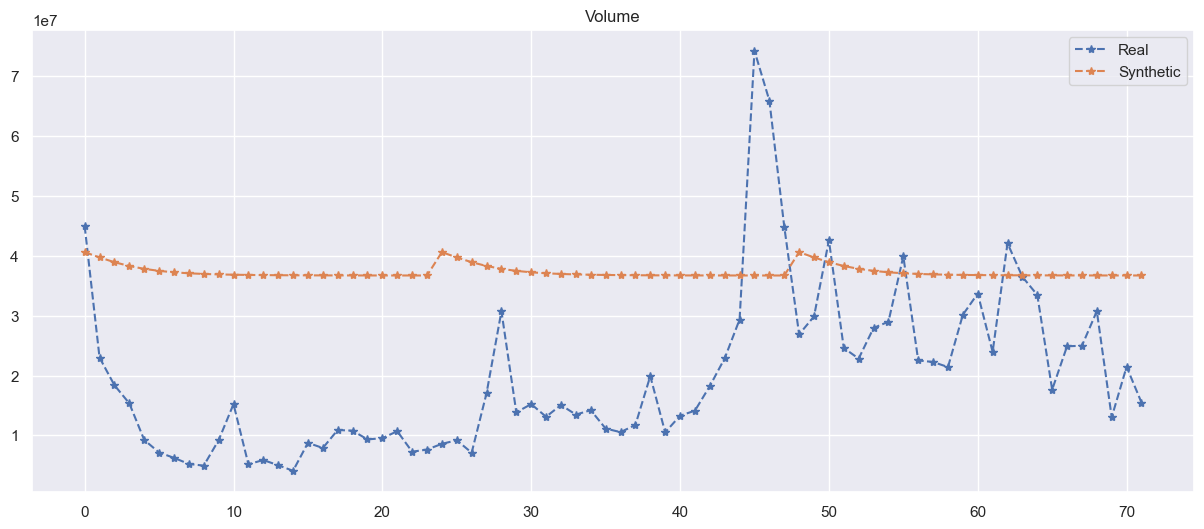

In [29]:
from paqarin.utils import plot_column_comparison
import matplotlib.pyplot as plt

figure_size: tuple[int, int] =(15, 6)
data_points:int = sequence_length * 3

for column_name in training_dataframe.columns:
    plot_column_comparison(real_sequence=training_dataframe.head(data_points)[column_name].reset_index(drop=True),
                           synthetic_sequence=synthetic_dataframe.head(data_points)[column_name].reset_index(drop=True),
                           column_name=column_name,
                           figure_size=figure_size)